In [41]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime, os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from skimage.io import imread
import os
from glob import glob
%matplotlib inline 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input as xception_preprocess_input

from tensorflow.keras.layers import GlobalMaxPooling2D, Dense,Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import Sequential , layers, models

from tensorflow.keras.models import Model


from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import xception

In [42]:
#loading dataframes
train_df = pd.read_csv('C:\\Users\\saish\\Projects\\Biometrics\\train.csv')
test_df = pd.read_csv('C:\\Users\\saish\\Projects\\Biometrics\\test.csv')

#appending file extension to id column for both training and testing dataframes
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x)+'.png') 

train_df.head()

id  boneage   male
0  1377.png      180  False
1  1378.png       12  False
2  1379.png       94  False
3  1380.png      120   True
4  1381.png       82  False

## Pre-processing of the x-ray images

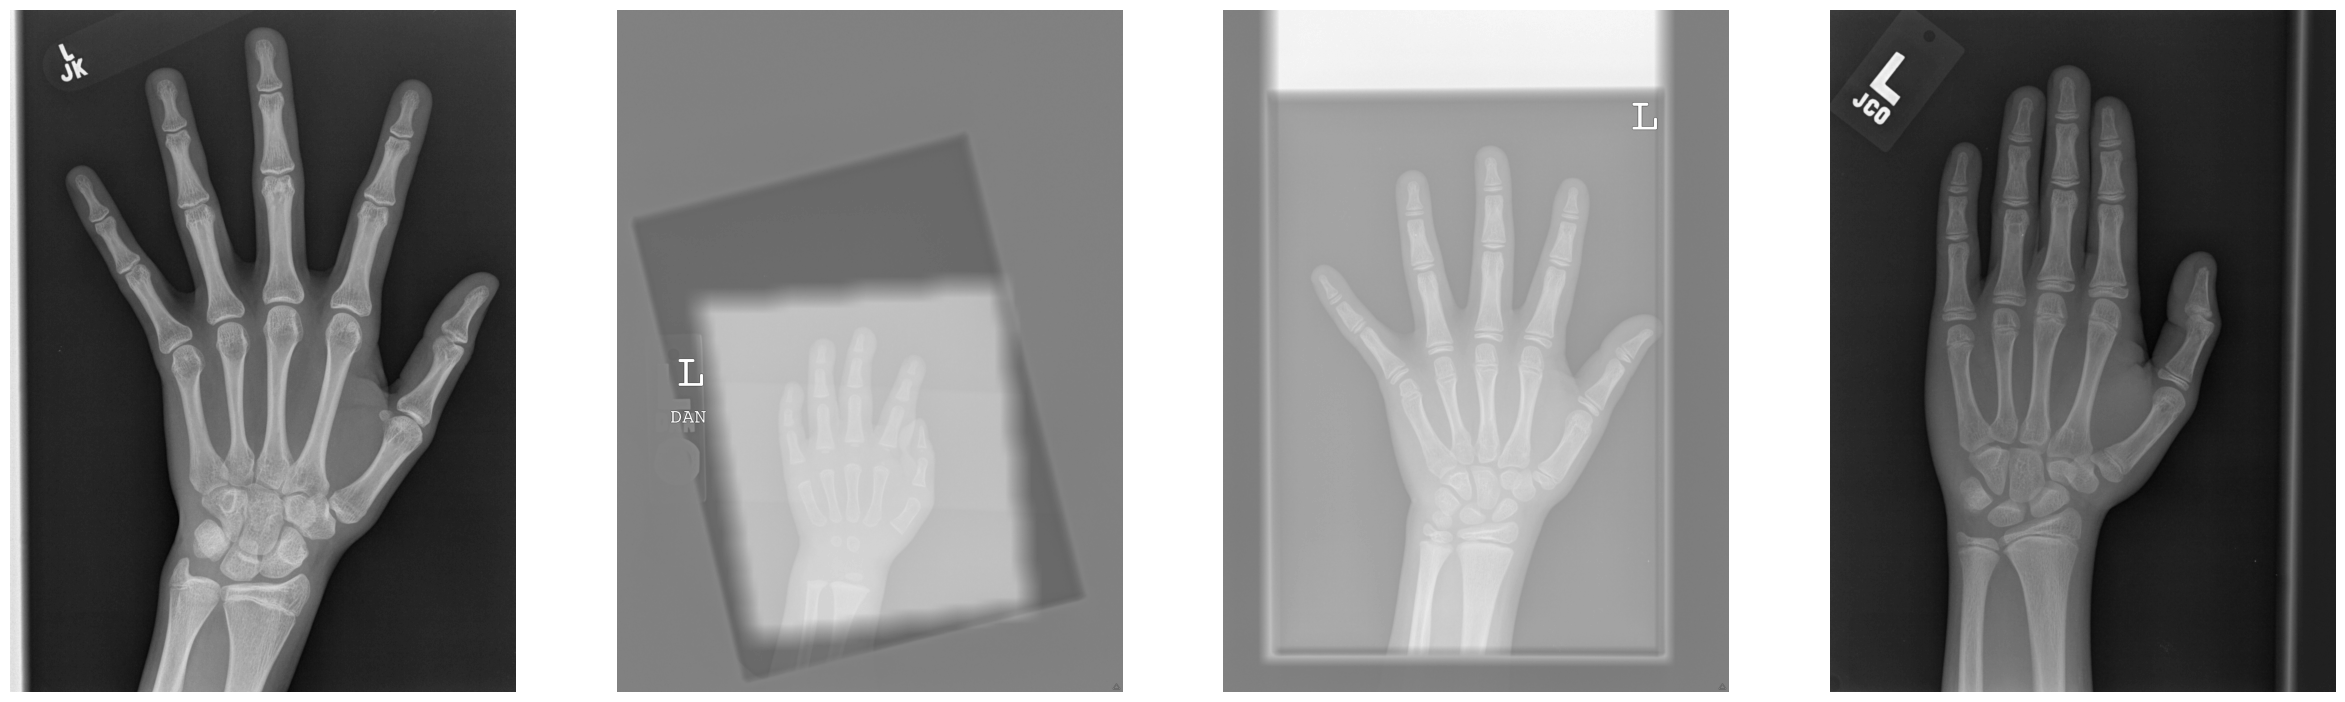

In [43]:
import imageio
num_imgs = 4
DIR = "C:\\Users\\saish\\Projects\\Biometrics\\Train dataset\\Data"
combined_xray_images_1 = np.array(
    [imageio.v3.imread(os.path.join(DIR, f"{1377+i}.png")) for i in range(num_imgs)]
)


fig, axes = plt.subplots(nrows=1, ncols=num_imgs, figsize=(30, 30))

for img, ax in zip(combined_xray_images_1, axes):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    

In [44]:
from scipy import ndimage
xray_image = imageio.v3.imread(os.path.join(DIR, "1380.png"))
xray_image_laplace_gaussian = ndimage.gaussian_laplace(xray_image, sigma=1)

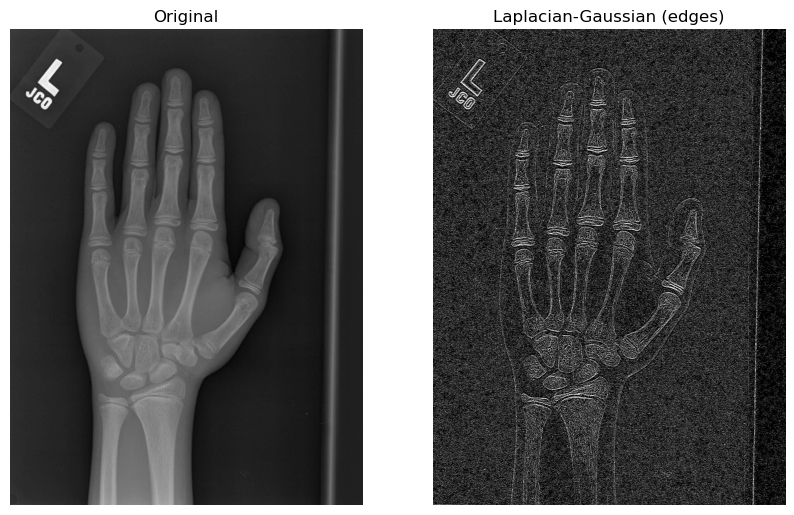

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

axes[0].set_title("Original")
axes[0].imshow(xray_image, cmap="gray")
axes[1].set_title("Laplacian-Gaussian (edges)")
axes[1].imshow(xray_image_laplace_gaussian, cmap="gray")
for i in axes:
    i.axis("off")
plt.show()

In [46]:
x_ray_image_gaussian_gradient = ndimage.gaussian_gradient_magnitude(xray_image, sigma=2)

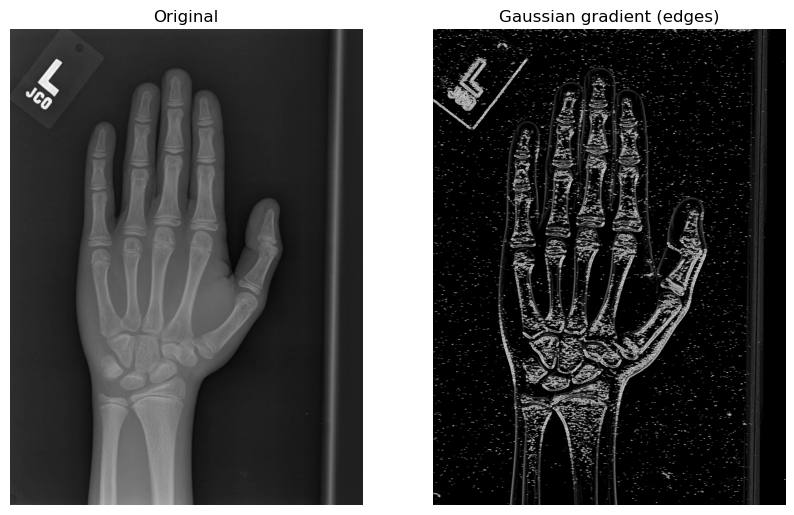

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

axes[0].set_title("Original")
axes[0].imshow(xray_image, cmap="gray")
axes[1].set_title("Gaussian gradient (edges)")
axes[1].imshow(x_ray_image_gaussian_gradient, cmap="gray")
for i in axes:
    i.axis("off")
plt.show()

In [48]:
x_sobel = ndimage.sobel(xray_image, axis=0)
y_sobel = ndimage.sobel(xray_image, axis=1)

xray_image_sobel = np.hypot(x_sobel, y_sobel)

xray_image_sobel *= 255.0 / np.max(xray_image_sobel)

In [49]:
print("The data type - before: ", xray_image_sobel.dtype)

xray_image_sobel = xray_image_sobel.astype("float32")

print("The data type - after: ", xray_image_sobel.dtype)

The data type - before:  float16
The data type - after:  float32


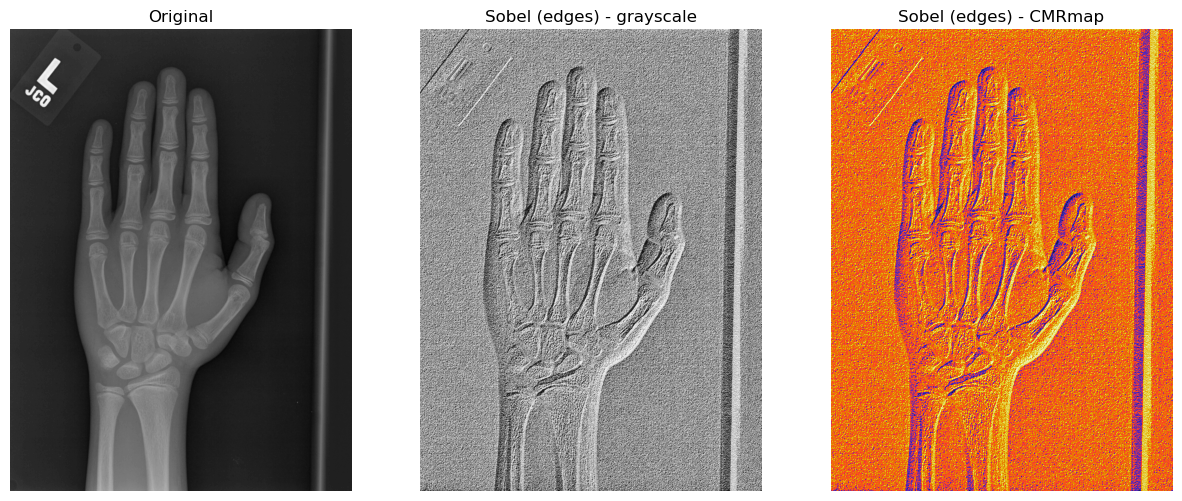

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))

axes[0].set_title("Original")
axes[0].imshow(xray_image, cmap="gray")
axes[1].set_title("Sobel (edges) - grayscale")
axes[1].imshow(xray_image_sobel, cmap="gray")
axes[2].set_title("Sobel (edges) - CMRmap")
axes[2].imshow(xray_image_sobel, cmap="CMRmap")
for i in axes:
    i.axis("off")
plt.show()

In [51]:
fourier_gaussian = ndimage.fourier_gaussian(xray_image, sigma=0.05)

x_prewitt = ndimage.prewitt(fourier_gaussian, axis=0)
y_prewitt = ndimage.prewitt(fourier_gaussian, axis=1)

xray_image_canny = np.hypot(x_prewitt, y_prewitt)

xray_image_canny *= 255.0 / np.max(xray_image_canny)

print("The data type - ", xray_image_canny.dtype)

The data type -  float64


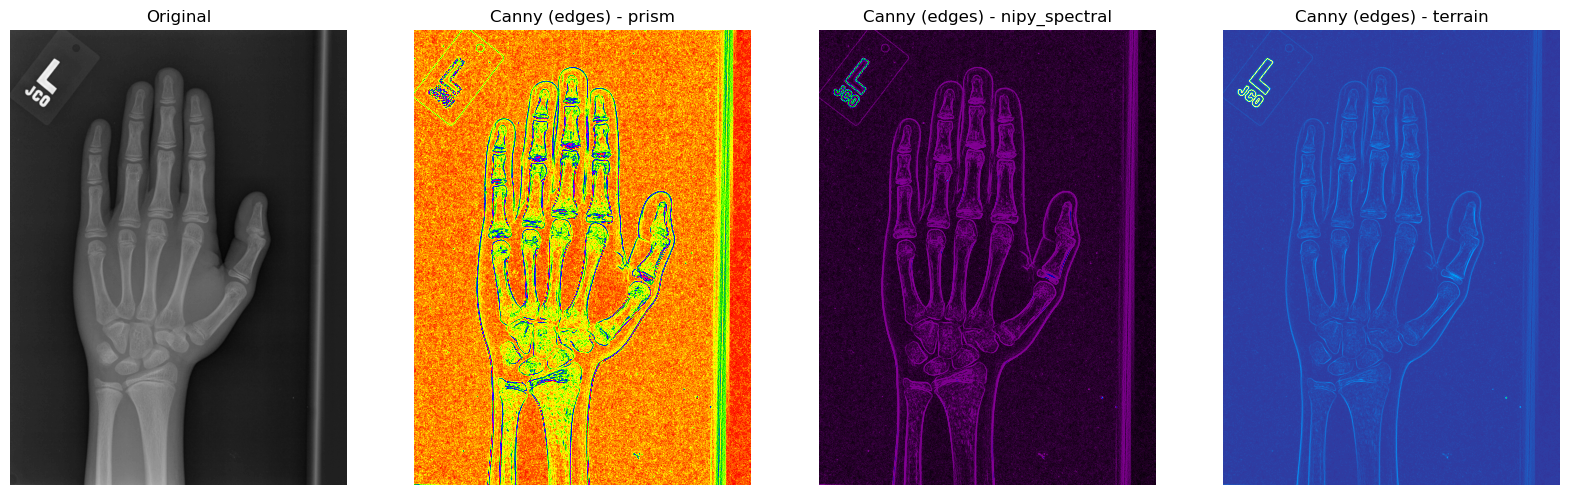

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 15))

axes[0].set_title("Original")
axes[0].imshow(xray_image, cmap="gray")
axes[1].set_title("Canny (edges) - prism")
axes[1].imshow(xray_image_canny, cmap="prism")
axes[2].set_title("Canny (edges) - nipy_spectral")
axes[2].imshow(xray_image_canny, cmap="nipy_spectral")
axes[3].set_title("Canny (edges) - terrain")
axes[3].imshow(xray_image_canny, cmap="terrain")
for i in axes:
    i.axis("off")
plt.show()

In [53]:
print("The data type of the X-ray image is: ", xray_image.dtype)
print("The minimum pixel value is: ", np.min(xray_image))
print("The maximum pixel value is: ", np.max(xray_image))
print("The average pixel value is: ", np.mean(xray_image))
print("The median pixel value is: ", np.median(xray_image))

The data type of the X-ray image is:  uint8
The minimum pixel value is:  0
The maximum pixel value is:  255
The average pixel value is:  56.964780444488106
The median pixel value is:  41.0


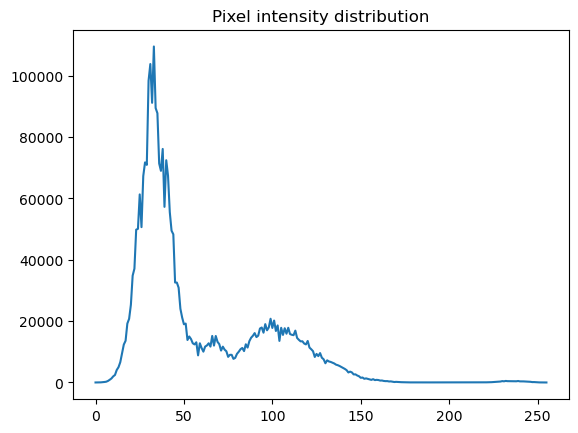

In [54]:
pixel_intensity_distribution = ndimage.histogram(
    xray_image, min=np.min(xray_image), max=np.max(xray_image), bins=256
)

plt.plot(pixel_intensity_distribution)
plt.title("Pixel intensity distribution")
plt.show()

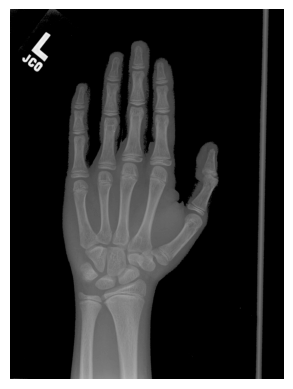

In [55]:
# The threshold is "greater than 150"
# Return the original image if true, `0` otherwise
xray_image_mask_noisy = np.where(xray_image > 60, xray_image, 0)

plt.imshow(xray_image_mask_noisy, cmap="gray")
plt.axis("off")
plt.show()

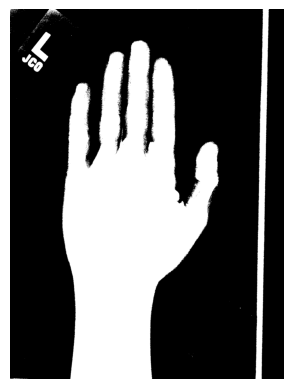

In [56]:
# The threshold is "greater than 150"
# Return `1` if true, `0` otherwise
xray_image_mask_less_noisy = np.where(xray_image > 60, 1, 0)

plt.imshow(xray_image_mask_less_noisy, cmap="gray")
plt.axis("off")
plt.show()

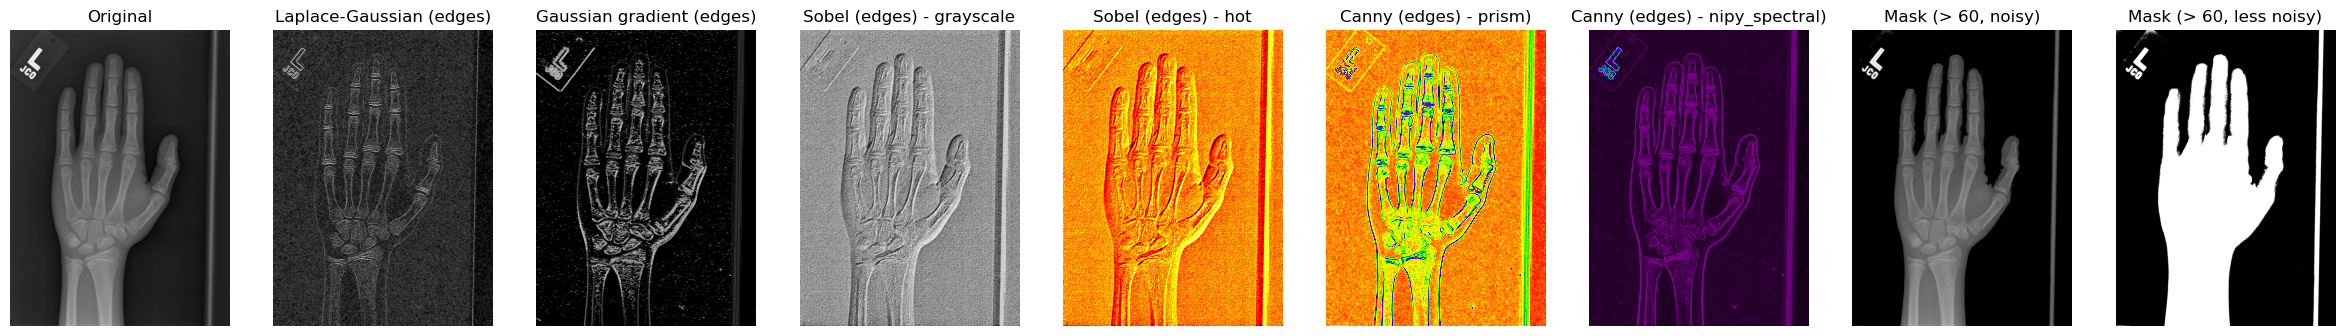

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=9, figsize=(30, 30))

axes[0].set_title("Original")
axes[0].imshow(xray_image, cmap="gray")
axes[1].set_title("Laplace-Gaussian (edges)")
axes[1].imshow(xray_image_laplace_gaussian, cmap="gray")
axes[2].set_title("Gaussian gradient (edges)")
axes[2].imshow(x_ray_image_gaussian_gradient, cmap="gray")
axes[3].set_title("Sobel (edges) - grayscale")
axes[3].imshow(xray_image_sobel, cmap="gray")
axes[4].set_title("Sobel (edges) - hot")
axes[4].imshow(xray_image_sobel, cmap="hot")
axes[5].set_title("Canny (edges) - prism)")
axes[5].imshow(xray_image_canny, cmap="prism")
axes[6].set_title("Canny (edges) - nipy_spectral)")
axes[6].imshow(xray_image_canny, cmap="nipy_spectral")
axes[7].set_title("Mask (> 60, noisy)")
axes[7].imshow(xray_image_mask_noisy, cmap="gray")
axes[8].set_title("Mask (> 60, less noisy)")
axes[8].imshow(xray_image_mask_less_noisy, cmap="gray")
for i in axes:
    i.axis("off")
plt.show()

# Feature Engineering

## Examine the distribution of age and gender

male      6833
female    5778
Name: gender, dtype: int64


<Axes: xlabel='gender', ylabel='count'>

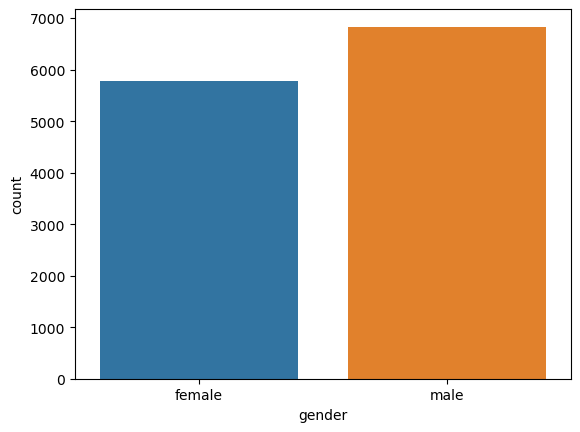

In [58]:
train_df['gender'] = train_df['male'].apply(lambda x: 'male' if x else 'female')
print(train_df['gender'].value_counts())
sns.countplot(x = train_df['gender'])

Text(0.5, 1.0, 'Number of people in each age group')

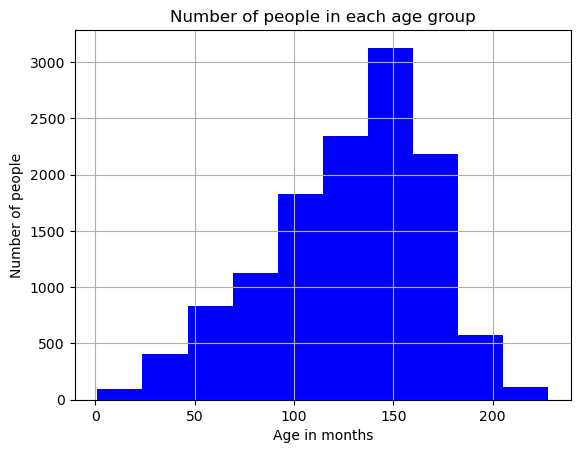

In [59]:
#plotting a histogram for bone ages
train_df['boneage'].hist(color = 'blue')
plt.xlabel('Age in months')
plt.ylabel('Number of people')
plt.title('Number of people in each age group')

In [60]:
#oldest person in the dataset
print('MAX age: ' + str(train_df['boneage'].max()) + ' months')

#youngest person in the dataset
print('MIN age: ' + str(train_df['boneage'].min()) + ' months')

#mean age is
mean_bone_age = train_df['boneage'].mean()
print('mean: ' + str(mean_bone_age))

#median bone age
print('median: ' +str(train_df['boneage'].median()))

#standard deviation of boneage
std_bone_age = train_df['boneage'].std()

train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)

print(train_df.head())

MAX age: 228 months
MIN age: 1 months
mean: 127.3207517246848
median: 132.0
         id  boneage   male  gender  bone_age_z
0  1377.png      180  False  female    1.279181
1  1378.png       12  False  female   -2.800269
2  1379.png       94  False  female   -0.809109
3  1380.png      120   True    male   -0.177766
4  1381.png       82  False  female   -1.100498


Text(0.5, 1.0, 'Relationship between number of people and bone age z score')

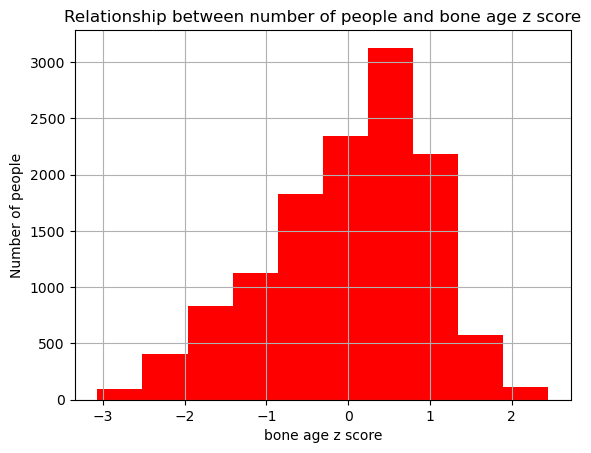

In [61]:
train_df['bone_age_z'].hist(color = 'red')
plt.xlabel('bone age z score')
plt.ylabel('Number of people')
plt.title('Relationship between number of people and bone age z score')

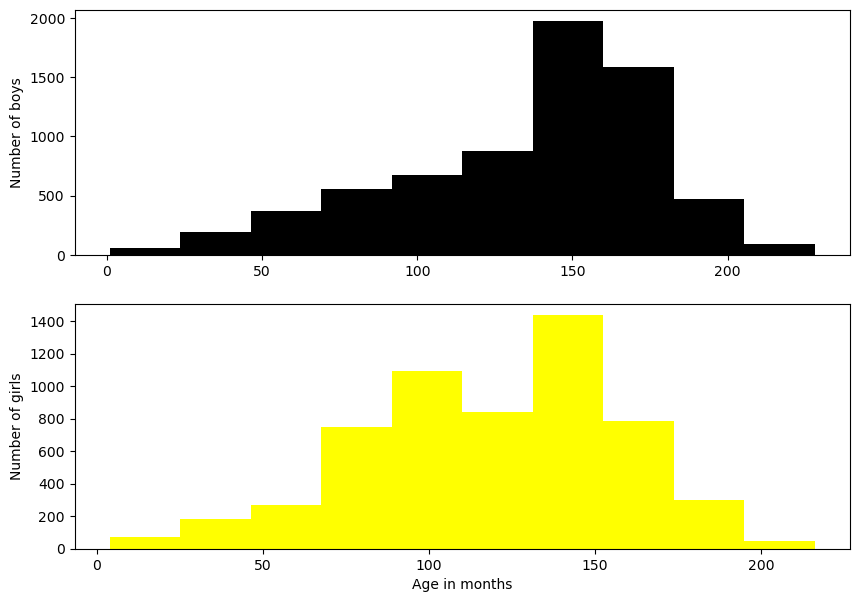

In [62]:
#distribution of age within each gender 

male = train_df[train_df['gender'] == 'male']
female = train_df[train_df['gender'] == 'female']
fig, ax = plt.subplots(2,1)
ax[0].hist(male['boneage'], color = 'black')
ax[0].set_ylabel('Number of boys')
ax[1].hist(female['boneage'], color = 'yellow')
ax[1].set_xlabel('Age in months')
ax[1].set_ylabel('Number of girls')
fig.set_size_inches((10,7))

In [69]:
#splitting train dataframe into traininng and validation dataframes
df_train, df_valid = train_test_split(train_df, test_size = 0.25, random_state = 0)

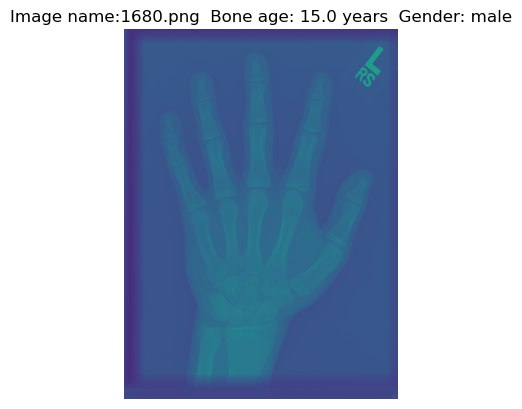

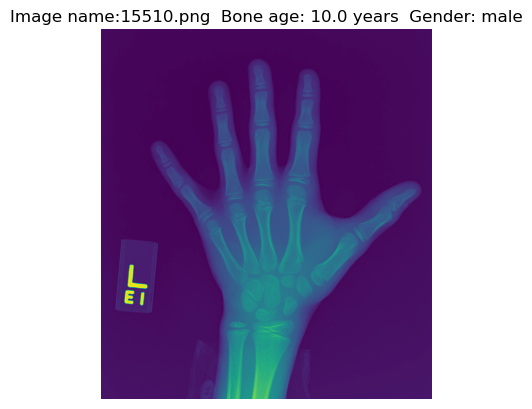

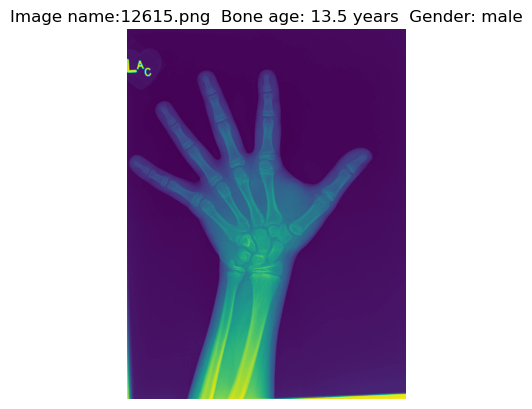

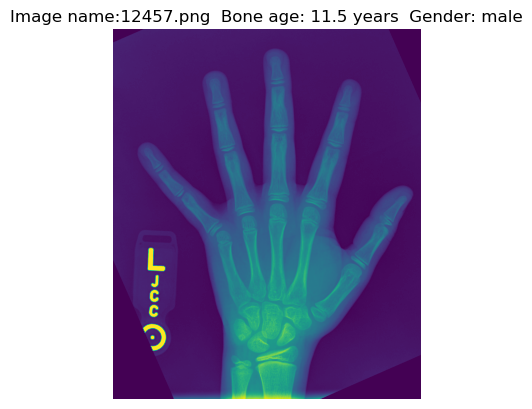

(1439, 1197)

In [101]:
import matplotlib.image as mpimg
for filename, boneage, gender in train_df[['id','boneage','gender']].sample(4).values:
    img = mpimg.imread('C:\\Users\\saish\\Projects\\Biometrics\\Train dataset\\Data\\'+ filename)
    plt.imshow(img)
    plt.title('Image name:{}  Bone age: {} years  Gender: {}'.format(filename, boneage/12, gender))
    plt.axis('off')
    plt.show()
img.shape

In [71]:
# reducing  the size of the image 
img_size = 128

train_data_generator = ImageDataGenerator(preprocessing_function = xception_preprocess_input)
val_data_generator = ImageDataGenerator(preprocessing_function = xception_preprocess_input)
test_data_generator = ImageDataGenerator(preprocessing_function = xception_preprocess_input)

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = 'C:\\Users\\saish\\Projects\\Biometrics\\Train dataset\\Data\\',
    x_col= 'id',
    y_col= 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode= 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))


val_generator = val_data_generator.flow_from_dataframe(
    dataframe = df_valid,
    directory = 'C:\\Users\\saish\\Projects\\Biometrics\\Train dataset\\Data\\',
    x_col = 'id',
    y_col = 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))



test_generator = test_data_generator.flow_from_directory(
    directory = 'C:\\Users\\saish\\Projects\\Biometrics\\Test_dataset',
    shuffle = True,
    class_mode = None,
    color_mode = 'rgb',
    target_size = (img_size,img_size))


Found 9458 validated image filenames.
Found 3153 validated image filenames.
Found 200 images belonging to 1 classes.


In [73]:
test_X, test_Y = next(val_data_generator.flow_from_dataframe( 
                            df_valid, 
                            directory = 'C:\\Users\\saish\\Projects\\Biometrics\\Train dataset\\Data\\',
                            x_col = 'id',
                            y_col = 'bone_age_z', 
                            target_size = (img_size, img_size),
                            batch_size = 3153,
                            class_mode = 'other'
                            )) 

Found 3153 validated image filenames.


# MODEL

In [74]:
from keras.metrics import mean_absolute_error
def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((std_bone_age*x_p + mean_bone_age), (std_bone_age*y_p + mean_bone_age)) 

In [75]:
def define_model(model_based, optimizer, loss , metrics , imsize):
    
    base_model = model_based(weights = 'imagenet', include_top = False, input_shape = (imsize, imsize, 3))
    
    base_model.trainable = True
            
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(10, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    output_layer = Dense(1, activation='linear')(x)
    
    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss=loss,
                  metrics= [metrics] )
    
    return model

In [77]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logs_dir = '.\logs'
%tensorboard --logdir {logs_dir}

In [78]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 5,
                              verbose=0, mode='auto')

#model checkpoint
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True)

#tensorboard callback
logdir = os.path.join(logs_dir,datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback =  TensorBoard(logdir, histogram_freq = 1)

#reduce lr on plateau
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callback_list = [tensorboard_callback,early_stopping,mc, red_lr_plat]

In [79]:
def train_model(epochs_num , model_to_train , callbacks):
    
   
    model_history = model_to_train.fit(train_generator,
                            steps_per_epoch = 315,
                            validation_data = val_generator,
                            validation_steps = 1,
                            epochs = epochs_num,
                            callbacks= callbacks)
    
    return model_history

In [80]:
model1_Compiled = define_model(model_based=tf.keras.applications.Xception, optimizer= 'adam', loss = "mse", metrics = mae_in_months , imsize = 128)
model1_History = train_model(epochs_num=15, model_to_train=model1_Compiled , callbacks = callback_list )

Epoch 1/15


C:\Users\saish\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


296/315 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.6649 - mae_in_months: 26.2152

C:\Users\saish\anaconda3\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


315/315 ━━━━━━━━━━━━━━━━━━━━ 846s 3s/step - loss: 0.6532 - mae_in_months: 25.9536 - val_loss: 0.1970 - val_mae_in_months: 14.6302 - learning_rate: 0.0010
Epoch 2/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 794s 2s/step - loss: 0.2976 - mae_in_months: 17.5009 - val_loss: 0.1926 - val_mae_in_months: 14.7455 - learning_rate: 0.0010
Epoch 3/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 834s 3s/step - loss: 0.2313 - mae_in_months: 15.4891 - val_loss: 0.2346 - val_mae_in_months: 16.3898 - learning_rate: 0.0010
Epoch 4/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 812s 3s/step - loss: 0.2246 - mae_in_months: 15.1034 - val_loss: 0.1226 - val_mae_in_months: 11.1593 - learning_rate: 0.0010
Epoch 5/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 811s 3s/step - loss: 0.2008 - mae_in_months: 14.2445 - val_loss: 0.2505 - val_mae_in_months: 15.4438 - learning_rate: 0.0010
Epoch 6/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 844s 3s/step - loss: 0.1818 - mae_in_months: 13.3382 - val_loss: 0.1506 - val_mae_in_months: 12.0967 - learning_rate: 0.0010
Epoch 7/15
315/315 ━━

In [81]:
def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

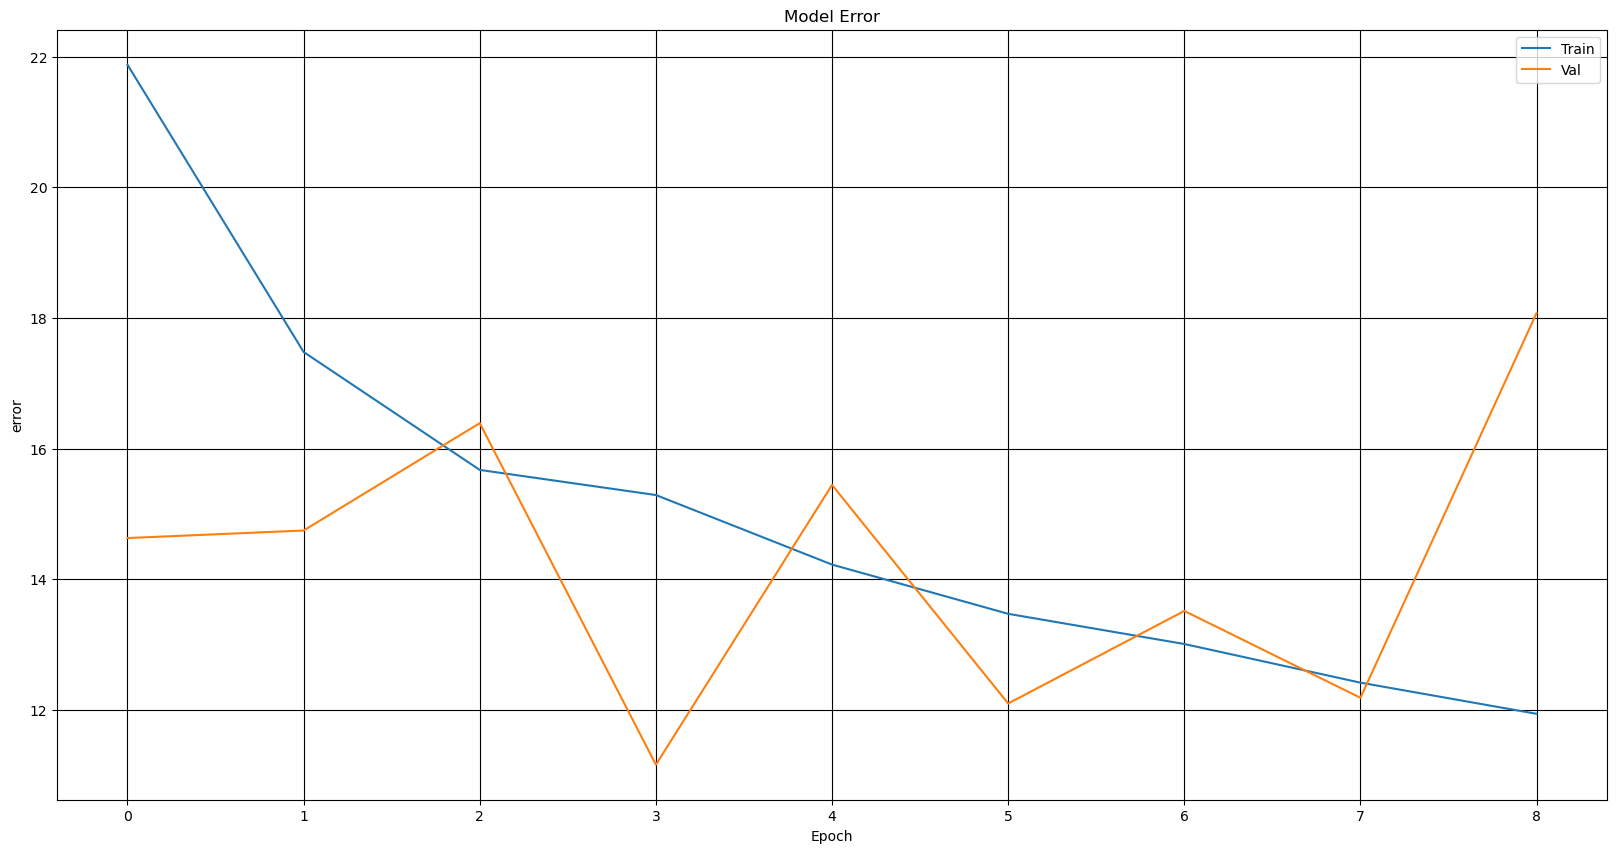

In [82]:
plot_it(model1_History)

99/99 ━━━━━━━━━━━━━━━━━━━━ 49s 479ms/step


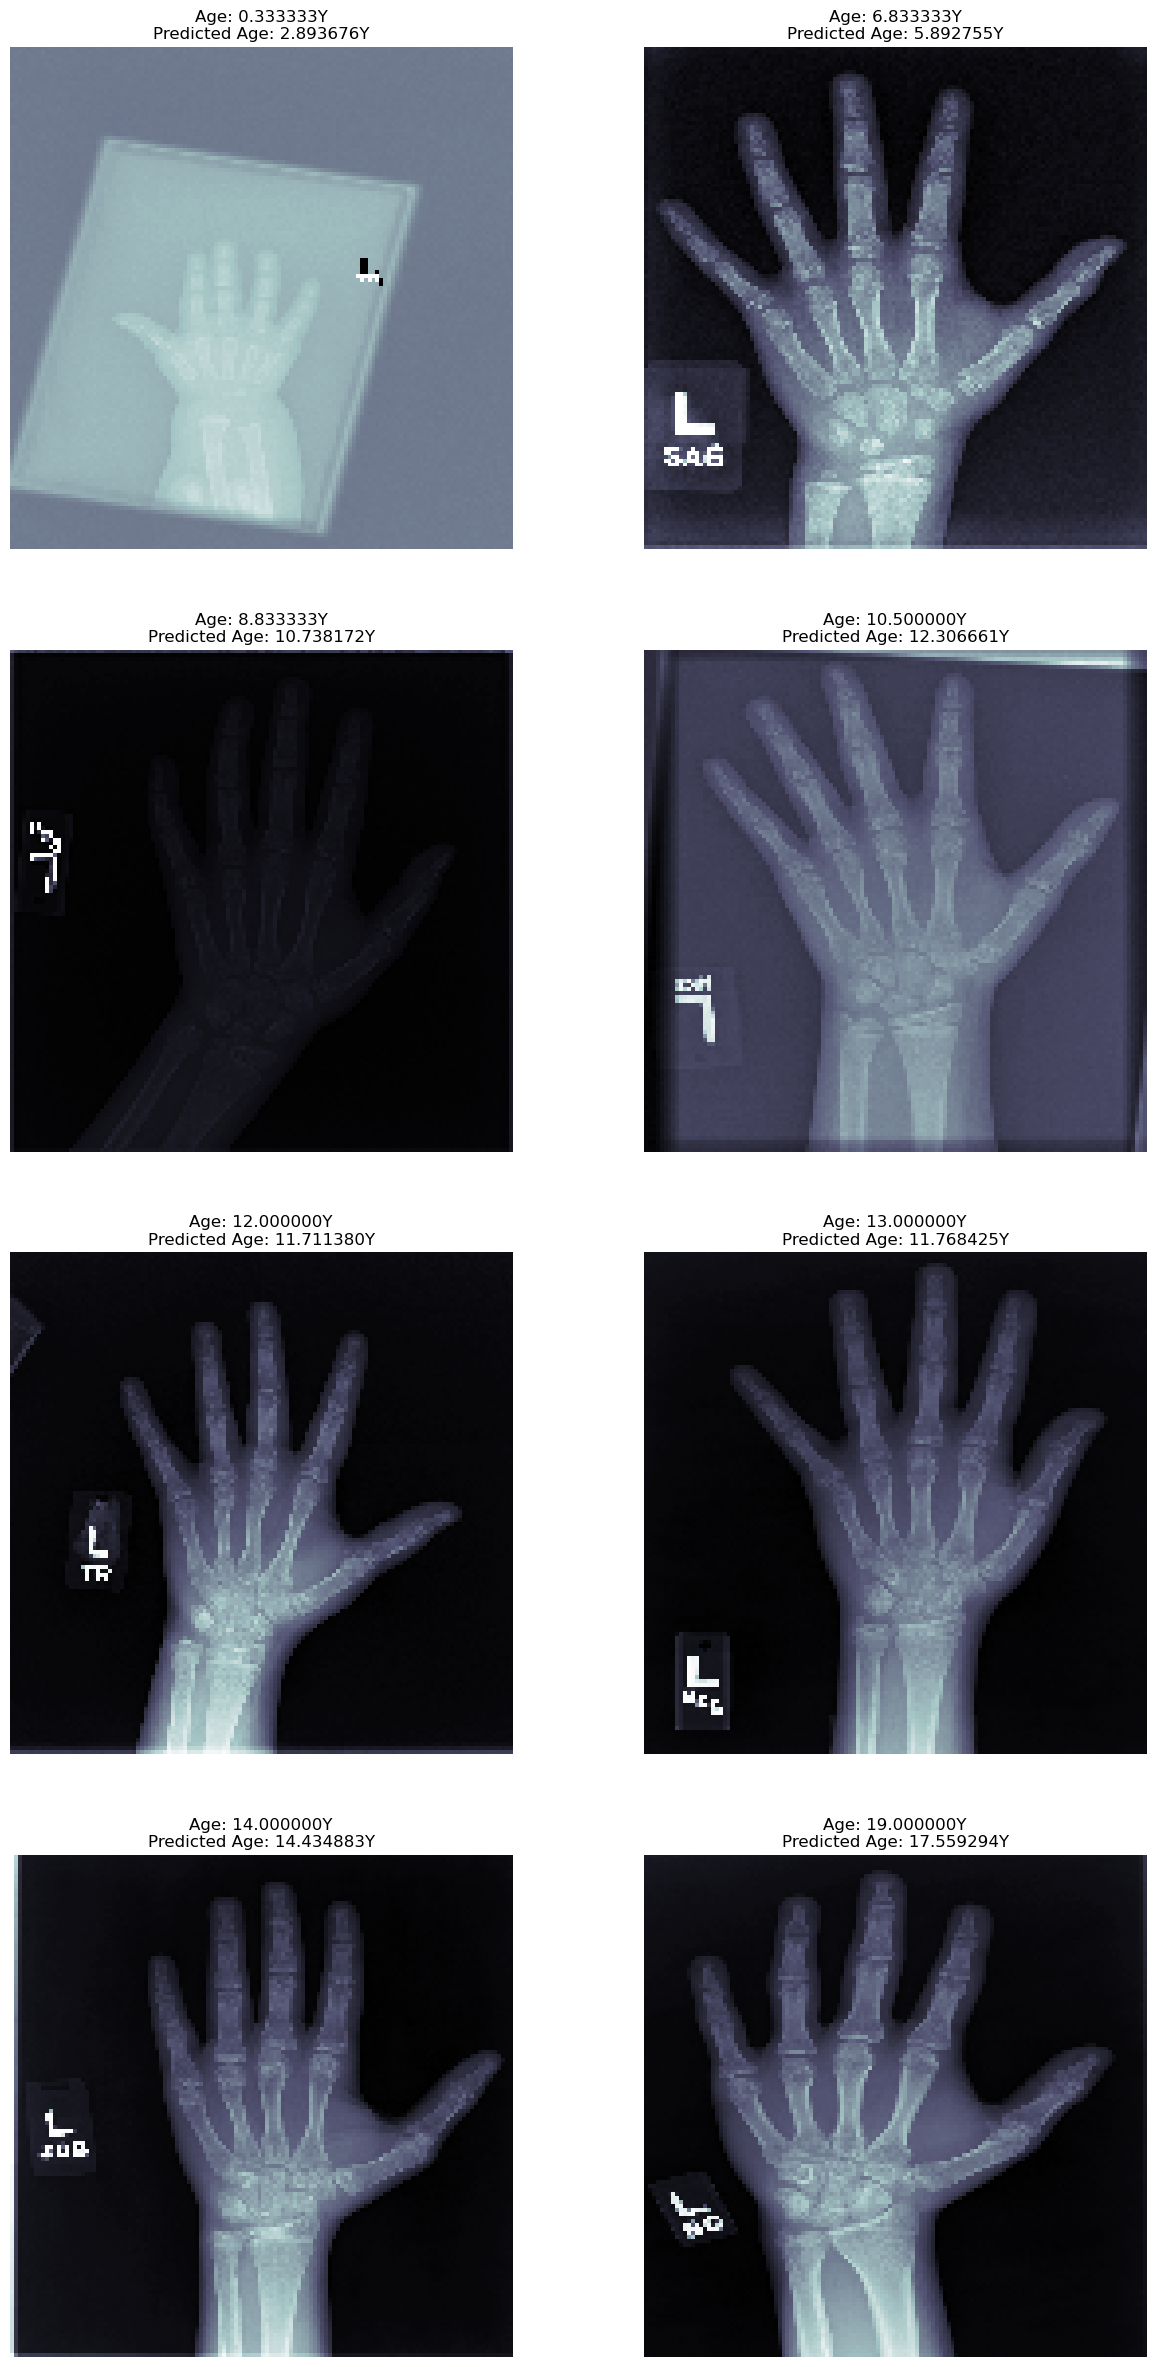

In [83]:
model1_Compiled.load_weights('best_model.keras')
pred = mean_bone_age + std_bone_age*(model1_Compiled.predict(test_X, batch_size = 32, verbose = True))
test_months = mean_bone_age + std_bone_age*(test_Y)

ord_ind = np.argsort(test_Y)
ord_ind = ord_ind[np.linspace(0, len(ord_ind)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, axs = plt.subplots(4, 2, figsize = (15, 30))
for (ind, ax) in zip(ord_ind, axs.flatten()):
    ax.imshow(test_X[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months[ind]/12.0, 
                                                           pred[ind]/12.0))
    ax.axis('off')
fig.savefig('trained_image_predictions.png', dpi = 300)

In [84]:
test_generator.reset()
y_pred = model1_Compiled.predict(test_generator)
predicted = y_pred.flatten()
predicted_months = mean_bone_age + std_bone_age*(predicted)
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions": predicted_months}
                    )
results.to_csv("results.csv",index=False)

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
